<style>
    .Aquamarine {
        background-color: #008B8B;
    }
</style>

<div class="Aquamarine">

<font align="center" color='white'>
    <h1/>Credit Card Fraud Detection</h1>
</font>

</div>

## Data Dictionary

Attribute|Description
-----|------------------------------|
index|Unique Identifier for each row
trans_date_trans_time|Transaction DateTime
cc_num|Credit Card Number of Customer
merchant|Merchant Name
category|Category of Merchant
amt|Amount of Transaction
first|First Name of Credit Card Holder
last|Last Name of Credit Card Holder
gender|Gender of Credit Card Holder
street|Street Address of Credit Card Holder
city|City of Credit Card Holder
state|State of Credit Card Holder
zip|Zip of Credit Card Holder
lat|Latitude Location of Credit Card Holder
long|Longitude Location of Credit Card Holder
city_pop|Credit Card Holder's City Population
job|Job of Credit Card Holder
dob|Date of Birth of Credit Card Holder
trans_num|Transaction Number
unix_time|UNIX Time of transaction
merch_lat|Latitude Location of Merchant
merch_long|Longitude Location of Merchant
is_fraud|Fraud Flag (Target Class)

# 0.0 Imports

In [1]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.proportion as sp
import scipy.stats as ss
import scikitplot as skp
import matplotlib.patches as pc



## Preprocess
import category_encoders as ce
from feature_engine.creation import CyclicalFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import sklearn.preprocessing as pp
from sklearn.compose import ColumnTransformer
from geopy.distance import distance, great_circle
from feature_engine import transformation as tr

# Imbalance
import imblearn as imb
import imblearn.pipeline as imb_pipe

## Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
import sklearn.metrics as mt


## Models
import tensorflow as ts
import lightgbm as lgbm
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

# Optmization
import optuna as opt
from optuna.samplers import TPESampler
from optuna import create_study, logging


## Experiments
import mlflow

# Explainability
import shap

e:\users\b_tc\anaconda3\envs\fraud_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

In [80]:
def plots_configs():

    #plt.style.use('ggplot')
    plt.rcParams.update({'figure.facecolor': (1.0, 1.0, 0.80, 0.15)})
    
    plt.rcParams['figure.figsize'] = (8, 4)
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    #plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.grid'] = False
    plt.rcParams['font.size'] = 13
    pd.options.display.max_columns = None
    plt.rcParams['font.sans-serif'] = 'Arial'
    pd.set_option('display.expand_frame_repr', False)
     
    #plt.rcParams.update({'figure.facecolor': (0.0, 0.0, 0.0, 0.0),
    #                     'axes.facecolor': (0.0, 0.0, 0.0, 0.0),
    #                     'savefig.facecolor': (0.0, 0.0, 0.0, 0.0)})
     
    
    #plt.rcParams['text.color'], plt.rcParams['axes.labelcolor'], plt.rcParams['xtick.color'], plt.rcParams['ytick.color'] = 'white', 'white', 'white', 'white'


### Feature Engineering
def city_size_by_pop(x):

    "Creates classes in respect to the size of the city taking i consideration the city's population."
    
    if x < 50000:
        return 'micro'
    if x >= 50000 and x < 100000:
        return 'small'
    elif x >= 100000 and x < 150000:
        return 'small_mid'
    elif x >= 150000 and x < 500000:
        return 'mid'
    else:
        return 'large'

def times_of_day(x):

    "Creates a label for the periods of the day."
    
    if x >= 0 and x <= 12:
        return 'morning'
    elif x > 12 and x <= 18:
        return 'afternoon'
    else:
        return 'evening'
    

def model_evaluation_metrics(model, X, y, cv, metrics):
    
    return pd.DataFrame(cross_validate(estimator=model, X=X, y=y, scoring=metrics, return_estimator=True, return_train_score=True, cv=cv))

def classifier_metrics_tuned(clf_name, y_val, y_prob):

    y_hat = (y_prob[:, 1] > 0.5).astype(int)

    precision = mt.precision_score(y_val, y_hat)
    accuracy = mt.accuracy_score(y_val, y_hat)
    recall = mt.recall_score(y_val, y_hat)
    f1_score = mt.f1_score(y_val, y_hat)
    rocauc = mt.roc_auc_score(y_val, y_prob[:, 1])
    

    return pd.DataFrame({clf_name: {'precision': precision, 'accuracy': accuracy, 'recall': recall, 'f1_score': f1_score, 'roc_auc': rocauc,}}).T
    

def evaluation_plot(y_true, y_prob):

    """
    This function plots 4 graphics — cumulative gain, lift curve, roc curve and precision recall curve — to evaluate the performance of a classifier.
    """


    cmap = sns.diverging_palette(150, 30, 180)
    #y_prob = model.predict_proba(X)
    y_hat = (y_prob[:, 1] > 0.5).astype(int)

    fig, axis = plt.subplots(2, 2, figsize=(16, 12))
    
    skp.metrics.plot_confusion_matrix(y_true, y_hat, ax=axis[0, 0], cmap='YlOrBr', text_fontsize=20)
    skp.metrics.plot_precision_recall(y_true, y_prob, ax=axis[0, 1], text_fontsize=20)
    skp.metrics.plot_roc(y_true, y_prob, ax=axis[1, 0], plot_micro=False, plot_macro=False, cmap='hot', text_fontsize=20)
    
    skp.metrics.plot_ks_statistic(y_true, y_prob, ax=axis[1, 1], text_fontsize=20)

    plt.tight_layout()


def track_model_experiments(model, X, y, cv, training_parameters, metrics, preprocess, columns, description=''):

    # adapted from https://github.com/OmdenaAI/sao-paulo-chapter-passenger-demand/blob/main/src/tasks/task_3_model_training_validation/ds_gustavo_cunha/0.0_gustavo-cunha_first_iteration.ipynb
    mlflow_experiment = 'fraud_classification_experiment_clf'

    try:
        experiment_id = mlflow.create_experiment(name=mlflow_experiment)

    except mlflow.exceptions.MlflowException:
        experiment_id = mlflow.get_experiment_by_name(name=mlflow_experiment).experiment_id

    model_tag = str(model).split('(')[0]

    pipe = Pipeline([('preprocessing', preprocess), (model_tag, model)])

    with mlflow.start_run(experiment_id=experiment_id, run_name=model_tag, tags={'experiment_type': 'fraud detection', 'model': model_tag}, description=description):

        results = pd.DataFrame(cross_validate(estimator=pipe, X=X, y=y, scoring=metrics, return_estimator=True, return_train_score=True, cv=cv))

        train_test_metrics = ['train_' + score for score in metrics] + ['test_' + score for score in metrics]
        track_metrics = {score: results[score].mean() for score in train_test_metrics}
  

        mlflow.log_params(training_parameters)
        mlflow.log_metrics(track_metrics)
        mlflow.log_param('columns', columns)

        mlflow.sklearn.log_model(pipe, artifact_path='mlruns/models', registered_model_name=model_tag)
        
    return results


def register_model(model, model_name, train_metrics, test_metrics,  params, metrics, columns, description):
    
    experiment = 'fraud_classification_test_performance'

    try:
        experiment_id = mlflow.create_experiment(name=experiment)
    except mlflow.exceptions.MlflowException:
        experiment_id = mlflow.get_experiment_by_name(name=experiment).experiment_id

    with mlflow.start_run(experiment_id=experiment_id, run_name=model_name, tags={'experiment_type': 'fraud detection', 'model': model_name}, description=description):


        track_metrics = {'train_'+score: train_metrics[score].values[0] for score in metrics} | {'test_'+score: test_metrics[score].values[0] for score in metrics}

        mlflow.log_params(params)
        mlflow.log_metrics(track_metrics)
        mlflow.log_param('columns', columns)

        mlflow.sklearn.log_model(model, artifact_path='mlruns/models', registered_model_name=model_name)

    return None


def track_model_experiments_resample(model, X, y, cv, training_parameters, metrics, preprocess, sampler, columns, description=''):

    # adaptad from https://github.com/OmdenaAI/sao-paulo-chapter-passenger-demand/blob/main/src/tasks/task_3_model_training_validation/ds_gustavo_cunha/0.0_gustavo-cunha_first_iteration.ipynb
    mlflow_experiment = 'fraud_classification_experiment_resampled'

    try:
        experiment_id = mlflow.create_experiment(name=mlflow_experiment)

    except mlflow.exceptions.MlflowException:
        experiment_id = mlflow.get_experiment_by_name(name=mlflow_experiment).experiment_id

    model_tag = str(model).split('(')[0]

    pipe = imb_pipe.Pipeline([('feat_eng', feat_eng), ('preprocessing', preprocess), ('sampler', sampler), (model_tag, model)])

    with mlflow.start_run(experiment_id=experiment_id, run_name=model_tag, tags={'experiment_type': 'fraud detection', 'model': model_tag}, description=description):

        results = pd.DataFrame(cross_validate(estimator=pipe, X=X, y=y, scoring=metrics, return_estimator=True, return_train_score=True, cv=cv))

        train_test_metrics = ['train_' + score for score in metrics] + ['test_' + score for score in metrics]
        track_metrics = {score: results[score].mean() for score in train_test_metrics}
  

        mlflow.log_params(training_parameters)
        mlflow.log_metrics(track_metrics)
        mlflow.log_param('columns', columns)

        mlflow.sklearn.log_model(pipe, artifact_path='mlruns/models', registered_model_name=model_tag)
        
    return results


def track_model_experiments_resample_two(model, X, y, cv, training_parameters, metrics, preprocess, sampler, sampler_2, columns, description=''):

    # adaptad from https://github.com/OmdenaAI/sao-paulo-chapter-passenger-demand/blob/main/src/tasks/task_3_model_training_validation/ds_gustavo_cunha/0.0_gustavo-cunha_first_iteration.ipynb
    mlflow_experiment = 'fraud_classification_experiment_resampled'

    try:
        experiment_id = mlflow.create_experiment(name=mlflow_experiment)

    except mlflow.exceptions.MlflowException:
        experiment_id = mlflow.get_experiment_by_name(name=mlflow_experiment).experiment_id

    model_tag = str(model).split('(')[0]

    pipe = imb_pipe.Pipeline([('feat_eng', feat_eng), ('preprocessing', preprocess), ('sampler', sampler), ('sampler_2', sampler_2), (model_tag, model)])

    with mlflow.start_run(experiment_id=experiment_id, run_name=model_tag, tags={'experiment_type': 'fraud detection', 'model': model_tag}, description=description):

        results = pd.DataFrame(cross_validate(estimator=pipe, X=X, y=y, scoring=metrics, return_estimator=True, return_train_score=True, cv=cv))

        train_test_metrics = ['train_' + score for score in metrics] + ['test_' + score for score in metrics]
        track_metrics = {score: results[score].mean() for score in train_test_metrics}
  

        mlflow.log_params(training_parameters)
        mlflow.log_metrics(track_metrics)
        mlflow.log_param('columns', columns)

        mlflow.sklearn.log_model(pipe, artifact_path='mlruns/models', registered_model_name=model_tag)
        
    return results


def plot_feature_importance(ordered_cols, imp):

    feature_importances = dict(zip(ordered_cols, imp))
    importance = list(feature_importances.values())
    featname = list(feature_importances.keys())

    # Ordering by Feature Importance
    ordered_index = np.argsort(importance)
    sorted_imp = [importance[i] for i in ordered_index[::-1]]
    sorted_features = [featname[i] for i in ordered_index[::-1]]

    # Plot
    plt.figure(figsize=(8, 12))
    bar = sns.barplot(y=sorted_features, x=sorted_imp)
    plt.bar_label(bar.containers[0], sorted_imp, label_type='edge', fmt='{:.3f}');

In [3]:
plots_configs()

## 0.2 Load Data

In [4]:
data = pd.read_csv("../data/fraudtrain.csv", dtype={'cc_number': object, 'zip': object}) #.drop(columns=['Unnamed: 0'])

# 3.0 Feature Engineering
<style>
    .Aquamarine {
        background-color: #008B8B;
    }
</style>

<div class="Aquamarine">

<font align="center" color='white'>
    <h1/></h1>
</font>

</div>

In [5]:
df_eng = data.copy()

In [6]:
def feature_engineering(df):

    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

    df['hour'] = df.trans_date_trans_time.dt.hour.values
    df['minute'] = df.trans_date_trans_time.dt.minute.values
    df['month'] = df.trans_date_trans_time.dt.month.values
    df['year'] = df.trans_date_trans_time.dt.year.values
    df['week'] = df.trans_date_trans_time.dt.isocalendar().week.values  
    df['day_of_week'] = df.trans_date_trans_time.dt.day_of_week.values + 1

    df['dob'] = pd.to_datetime(df['dob'])

    df['age'] = ((df['trans_date_trans_time'].max() - df['dob']).dt.days/365).astype(int)

    df['over_60_years'] = df['age'].apply(lambda x: 'No' if x < 60 else 'Yes')

    amount_avg_by_person = df.groupby(['first', 'last']).median(numeric_only=True)[['amt']].reset_index().rename(columns={'amt': 'median_amount'})

    df = pd.merge(df, amount_avg_by_person, on=['first', 'last'], how='left')

    df['amount_diff_from_median'] = (df['amt'] - df['median_amount'])

    df['amount_diff_from_median_perc'] = (df['amt'] - df['median_amount'])/df['median_amount']

    df['city_size'] = df['city_pop'].apply(lambda x: city_size_by_pop(x))
    
    df['day_time'] = df['trans_date_trans_time'].apply(lambda x: times_of_day(x.hour))

    df['distance'] = df[['lat', 'long', 'merch_lat', 'merch_long']].apply(lambda x: great_circle((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).km, axis=1)

    # Average per category
    cat_amt = df[['category', 'amt', 'hour']].groupby('category').mean().rename(columns={'amt': 'amount_category', 'hour': 'hour_category'})

    df = df.merge(cat_amt, on='category', how='left')
        
    return df

In [7]:
feat_eng = pp.FunctionTransformer(feature_engineering)

# 5.0 Preprocessing
<style>
    .Aquamarine {
        background-color: #008B8B;
    }
</style>

<div class="Aquamarine">

<font align="center" color='white'>
    <h1/></h1>
</font>

</div>

In [11]:
# pass columns
pass_cols = [
              'lat',
              'long',
              'merch_lat',
              'merch_long',
            ]

# numeric
robust_cols = [
                 'age',
                 #'amount_category',
                 #'hour_category'
              ]

log_cols = [
              'amt',
              'city_pop',
              
            ]

oneh_cols = [
    
              'gender',

              'day_time',

              'category',
            ]


cyclic_cols = [
                'hour',
                #'week',
                #'year'
              ]

In [12]:
# Feature creation and Transformations
#feat_eng = pp.FunctionTransformer(feature_engineering)

robust_sc = pp.RobustScaler()
robust_transformer = Pipeline([('robust_scaler', robust_sc)])

std_sc = pp.StandardScaler()
std_transformer = Pipeline([('std_scaler', std_sc)])


log = tr.LogTransformer()
log_transformer = Pipeline([('log_trans', log)])

onehot = pp.OneHotEncoder(handle_unknown='ignore', drop='first')
onehot_transformer = Pipeline([('onehot_enc', onehot)])

woe_encoder = ce.woe.WOEEncoder()
#freq_enc = enc.FrequencyEncoder()


# Cyclical
cyclical = CyclicalFeatures(variables=None, drop_original=True)

transformer = ColumnTransformer([
                                    ('onehot', onehot_transformer, oneh_cols),
                                    ('robust', robust_transformer, robust_cols),
                                    ('log', log_transformer, log_cols),
                                    ('cyclic', cyclical, cyclic_cols),
                                    ('pass', 'passthrough', pass_cols),
                                    

                                    
                                   ], sparse_threshold=0)

preprocessing = Pipeline(steps=[
                                ('feature_engineering', feat_eng), 
                                ('transformer', transformer),])

In [13]:
X_train = data.copy().drop(columns=['is_fraud'])
y_train = data.copy()['is_fraud']

In [54]:
test = pd.read_csv("../data/fraudTest.csv", dtype={'cc_number': object, 'zip': object}).drop(columns=['Unnamed: 0'])

X_test = test.copy().drop(columns=['is_fraud'])
y_test = test.copy()['is_fraud'].values

# 6.0 Model Testing
<style>
    .Aquamarine {
        background-color: #008B8B;
    }
</style>

<div class="Aquamarine">

<font align="center" color='white'>
    <h1/></h1>
</font>

</div>

**Defining The Evaluation Metric**

In [14]:
cols = np.concatenate([
    oneh_cols, 
    log_cols, 
    robust_cols,
    #std_cols,
    pass_cols, 
    cyclic_cols])

## 6.1 XGboost

In [15]:
params = dict(n_jobs=-1)
model = xgb.XGBClassifier(**params, random_state=42)
results = track_model_experiments(model=model, X=X_train, y=y_train.values, cv=5, training_parameters=params, metrics=['f1', 'recall', 'accuracy', 'roc_auc', 'precision', 'balanced_accuracy'], preprocess=preprocessing, columns=cols, description='Categorical: onehot, category:WOE, Numerical: Robust and Log (amt, pop), Cyclic time Cols, Pass: geo')

Setuptools is replacing distutils.
Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2023/09/06 07:58:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 61
Created version '61' of model 'XGBClassifier'.


In [16]:
results

,fit_time,score_time,estimator,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_precision,train_precision,test_balanced_accuracy,train_balanced_accuracy
0,70.039783,15.369081,((FunctionTransformer(func=<function feature_e...,0.852996,0.926919,0.763491,0.877602,0.998477,0.999199,0.996586,0.999765,0.966273,0.982110,0.881668,0.938754
1,71.255868,15.721725,((FunctionTransformer(func=<function feature_e...,0.859329,0.929439,0.785476,0.879600,0.998512,0.999227,0.996365,0.999774,0.948512,0.985264,0.892614,0.939762
2,70.524843,15.563626,((FunctionTransformer(func=<function feature_e...,0.872936,0.926589,0.810127,0.875437,0.998635,0.999197,0.997589,0.999769,0.946304,0.984088,0.904929,0.937677
3,70.316066,15.592804,((FunctionTransformer(func=<function feature_e...,0.858927,0.925347,0.778814,0.872107,0.998519,0.999185,0.998123,0.999740,0.957412,0.985510,0.889306,0.936016
4,70.318274,15.662248,((FunctionTransformer(func=<function feature_e...,0.867925,0.926214,0.796272,0.873917,0.998596,0.999194,0.998010,0.999730,0.953748,0.985167,0.898023,0.936920


In [17]:
params = dict(n_jobs=-1)
model = xgb.XGBClassifier(**params, random_state=42)
pipe = Pipeline([('preprocessing', preprocessing), ('xgb', model)])

y_proba = cross_val_predict(estimator=pipe, X=X_train, y=y_train, method='predict_proba')

In [18]:
onehot_out = results.estimator[0][0][1].named_transformers_['onehot'].get_feature_names_out()
cyclic_out = results.estimator[0][0][1].named_transformers_['cyclic'].get_feature_names_out()
columns = np.concatenate([onehot_out, woe_cols, log_cols, robust_cols, pass_cols, cyclic_out])
importances = results.estimator[0][1].feature_importances_

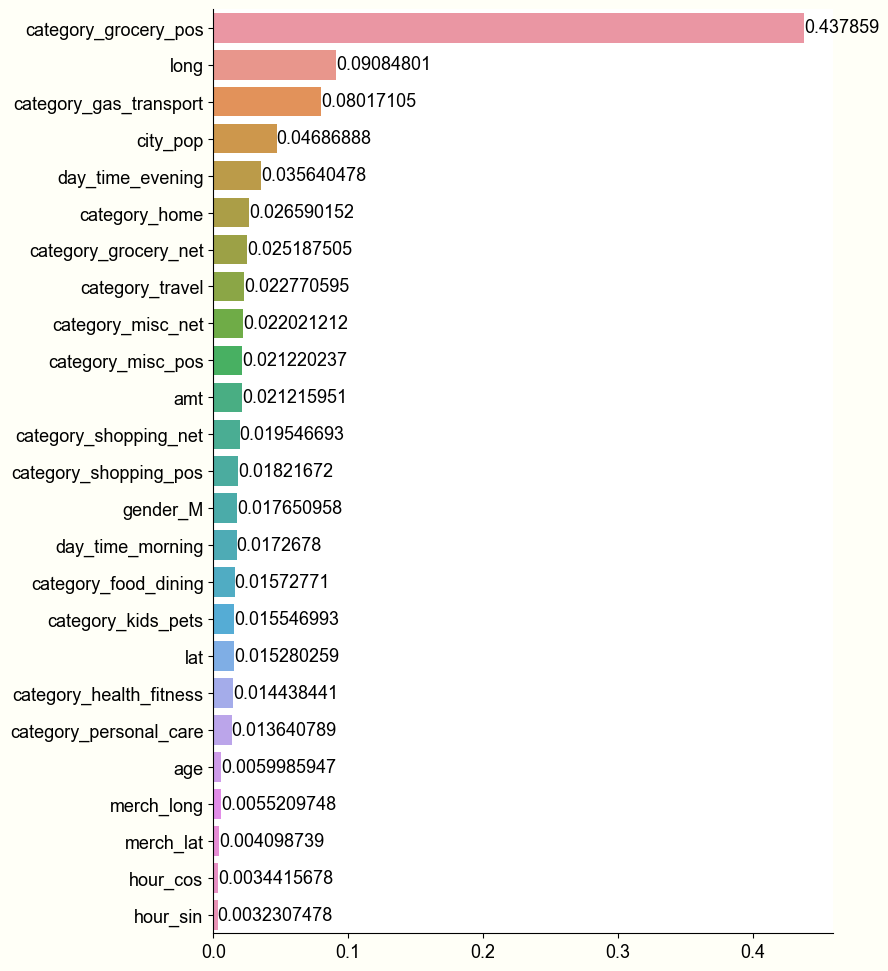

In [19]:
plot_feature_importance(ordered_cols=columns, imp=importances)

## 6.2 Random Undersampling + XGBoost

In [20]:
scale = 5/14
sampler = imb.under_sampling.RandomUnderSampler(sampling_strategy=scale, random_state=42)

In [21]:
params = dict(n_jobs=-1)
model = xgb.XGBClassifier(**params)
results_usamp = track_model_experiments_resample(model=model, X=X_train, y=y_train.values, cv=5, training_parameters=params, metrics=['f1', 'recall', 'accuracy', 'roc_auc', 'precision', 'balanced_accuracy'], preprocess=transformer, sampler=sampler, columns=cols, description=f'Categorical: onehot, category:WOE, Numerical: Robust, Pass: Geo, Cyclic Features - Random Undersampling ({scale})')

Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2023/09/06 08:14:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 62
Created version '62' of model 'XGBClassifier'.


In [22]:
results_usamp

,fit_time,score_time,estimator,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_precision,train_precision,test_balanced_accuracy,train_balanced_accuracy
0,32.170802,15.571953,(FunctionTransformer(func=<function feature_en...,0.495997,0.530166,0.928714,0.998002,0.989076,0.989760,0.996850,0.999354,0.338350,0.360959,0.959071,0.993857
1,32.123516,15.568899,(FunctionTransformer(func=<function feature_en...,0.513675,0.537964,0.944704,0.998168,0.989647,0.990075,0.997273,0.999368,0.352736,0.368204,0.967306,0.994098
2,31.976791,15.916420,(FunctionTransformer(func=<function feature_en...,0.510447,0.532162,0.944037,0.998834,0.989519,0.989834,0.997527,0.999380,0.349790,0.362702,0.966911,0.994308
3,32.161083,15.595016,(FunctionTransformer(func=<function feature_en...,0.495043,0.526649,0.948035,0.998834,0.988806,0.989606,0.997633,0.999428,0.334981,0.357599,0.968539,0.994193
4,31.892263,15.549614,(FunctionTransformer(func=<function feature_en...,0.494203,0.520324,0.950732,0.998834,0.988729,0.989341,0.997731,0.999380,0.333879,0.351792,0.969841,0.994060


## 6.3 SMOTE Oversampling + XGBoost

In [23]:
# Over sampling and undersampling strategy
over_sc = 0.1
ovu_samp = imb.over_sampling.SMOTE(random_state=42, sampling_strategy=0.1)


In [25]:
params = dict(n_jobs=-1)
model = xgb.XGBClassifier(**params)
results_over = track_model_experiments_resample(model=model, X=X_train, y=y_train.values, cv=5, training_parameters=params, metrics=['f1', 'recall', 'accuracy', 'roc_auc', 'precision', 'balanced_accuracy'], preprocess=transformer, sampler=ovu_samp, columns=cols, description=f'Categorical: onehot, category:WOE, Numerical: Robust, Pass: Geo, Cyclic Features - SMOTE ({over_sc}))')

Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2023/09/06 09:44:57 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 63
Created version '63' of model 'XGBClassifier'.


In [26]:
results_over

,fit_time,score_time,estimator,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_precision,train_precision,test_balanced_accuracy,train_balanced_accuracy
0,80.106601,15.786860,(FunctionTransformer(func=<function feature_en...,0.855391,0.917426,0.790140,0.879767,0.998454,0.999083,0.997328,0.999530,0.932390,0.958454,0.894903,0.939772
1,76.517668,15.487351,(FunctionTransformer(func=<function feature_en...,0.859463,0.915966,0.810793,0.879434,0.998465,0.999066,0.996790,0.999542,0.914350,0.955664,0.905175,0.939598
2,76.115463,15.644345,(FunctionTransformer(func=<function feature_en...,0.868004,0.920605,0.821452,0.887261,0.998554,0.999114,0.997202,0.999567,0.920149,0.956553,0.910519,0.943513
3,77.808750,15.705689,(FunctionTransformer(func=<function feature_en...,0.860169,0.917812,0.811459,0.884263,0.998473,0.999083,0.998017,0.999511,0.915101,0.954006,0.905510,0.942007
4,79.011909,15.613673,(FunctionTransformer(func=<function feature_en...,0.871196,0.915677,0.819574,0.879913,0.998596,0.999062,0.998265,0.999513,0.929758,0.954472,0.909607,0.939835


## 6.4 SMOTE and Random Undersampling + XGBoost

In [155]:
# Over sampling and undersampling strategy
over_sc = 0.1
under_sc  = 0.6
ovu_samp = imb.over_sampling.SMOTE(random_state=42, sampling_strategy=0.1)
u_sampler = imb.under_sampling.RandomUnderSampler(sampling_strategy=0.5, random_state=42)


In [156]:
params = dict(n_jobs=-1)
model = xgb.XGBClassifier(**params)
results_ovu = track_model_experiments_resample_two(model=model, X=X_train, y=y_train.values, cv=5, training_parameters=params, metrics=['f1', 'recall', 'accuracy', 'roc_auc', 'precision', 'balanced_accuracy'], preprocess=transformer, sampler=ovu_samp, sampler_2=u_sampler,  columns=cols, description=f'Categorical: onehot, category:WOE, Numerical: Robust, Pass: Geo, Cyclic Features - SMOTE ({over_sc} + UnderS ({under_sc}))')

Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2023/09/07 01:18:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 66
Created version '66' of model 'XGBClassifier'.


In [157]:
results_ovu

,fit_time,score_time,estimator,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_precision,train_precision,test_balanced_accuracy,train_balanced_accuracy
0,46.271480,15.723587,(FunctionTransformer(func=<function feature_en...,0.789911,0.848476,0.855430,0.945545,0.997366,0.998045,0.997682,0.999599,0.733714,0.769481,0.926811,0.971948
1,45.797662,15.952649,(FunctionTransformer(func=<function feature_en...,0.795427,0.852027,0.880746,0.946878,0.997378,0.998096,0.997264,0.999591,0.725178,0.774448,0.939402,0.972636
2,44.633453,15.849128,(FunctionTransformer(func=<function feature_en...,0.797211,0.845643,0.876083,0.942881,0.997420,0.998007,0.997466,0.999570,0.731368,0.766585,0.937105,0.970605
3,45.062555,15.837273,(FunctionTransformer(func=<function feature_en...,0.799640,0.850157,0.886742,0.943880,0.997428,0.998074,0.998158,0.999598,0.728118,0.773366,0.942407,0.971135
4,43.974904,15.227307,(FunctionTransformer(func=<function feature_en...,0.792239,0.841152,0.883489,0.943704,0.997316,0.997937,0.998094,0.999563,0.718074,0.758704,0.940734,0.970978


## 6.5 Positive Class Weight

In [30]:
pos_weight=4/1
params = dict(n_jobs=-1, scale_pos_weight=pos_weight)
model = xgb.XGBClassifier(**params, random_state=42, )
results_scale = track_model_experiments(model=model, X=X_train, y=y_train.values, cv=5, training_parameters=params, metrics=['f1', 'recall', 'accuracy', 'roc_auc', 'precision', 'balanced_accuracy'], preprocess=preprocessing, columns=cols, description=f'Categorical: onehot, category:WOE, Numerical: Robust and Log (amt, pop), Cyclic time Cols, Pass: geo - pos_class_weight={pos_weight}')

Registered model 'XGBClassifier' already exists. Creating a new version of this model...
2023/09/06 10:08:15 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: XGBClassifier, version 65
Created version '65' of model 'XGBClassifier'.


In [31]:
results_scale

,fit_time,score_time,estimator,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_precision,train_precision,test_balanced_accuracy,train_balanced_accuracy
0,74.540329,15.816491,((FunctionTransformer(func=<function feature_e...,0.849440,0.942609,0.808128,0.947710,0.998342,0.999332,0.996303,0.999893,0.895203,0.937562,0.903789,0.973671
1,72.567554,15.530120,((FunctionTransformer(func=<function feature_e...,0.849521,0.935824,0.827448,0.947044,0.998303,0.999248,0.997092,0.999885,0.872804,0.924866,0.913373,0.973298
2,84.436011,15.658348,((FunctionTransformer(func=<function feature_e...,0.857918,0.933016,0.842771,0.947544,0.998384,0.999212,0.997371,0.999876,0.873619,0.918928,0.921031,0.973528
3,73.174615,15.784290,((FunctionTransformer(func=<function feature_e...,0.844810,0.938211,0.821452,0.948210,0.998253,0.999277,0.997826,0.999895,0.869535,0.928420,0.910367,0.973892
4,70.901106,15.680412,((FunctionTransformer(func=<function feature_e...,0.856948,0.930321,0.835553,0.936209,0.998384,0.999188,0.998180,0.999863,0.879467,0.924507,0.917443,0.967882


## 6.6 Summary results of the cross-validation

In [32]:
# summary
filter_cols = list(filter(lambda x: x.__contains__('test'), results.columns.to_list()))


summary = pd.concat([results[filter_cols].mean(axis=0), results_usamp[filter_cols].mean(axis=0)], axis=1) 
summary = pd.concat([summary, results_over[filter_cols].mean(axis=0)], axis=1)
summary = pd.concat([summary, results_ovu[filter_cols].mean(axis=0)], axis=1)
summary = pd.concat([summary, results_scale[filter_cols].mean(axis=0)], axis=1)

summary.columns =  ['XGB - no resampling', 'XGB + Random Undersampling', 'XGB + SMOTE', 'XGB + SMOTE and Undersampling', 'XGB + Scale pos weight']

In [33]:
summary

,XGB - no resampling,XGB + Random Undersampling,XGB + SMOTE,XGB + SMOTE and Undersampling,XGB + Scale pos weight
test_f1,0.862423,0.501873,0.862845,0.794886,0.851727
test_recall,0.786836,0.943244,0.810684,0.876498,0.827071
test_accuracy,0.998548,0.989155,0.998508,0.997382,0.998333
test_roc_auc,0.997335,0.997403,0.997520,0.997733,0.997354
test_precision,0.954450,0.341947,0.922350,0.727291,0.878126
test_balanced_accuracy,0.893308,0.966334,0.905143,0.937292,0.913201


## Fine Tuning

In [34]:
def objective(trial, x, y):

    # Defining parameters
    params = {
        'objective': 'binary:logistic',
        #'verbosity': 0,
        #'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda',  1e-4, 1e-1, log=True),
        #'max_leaves': trial.suggest_int('num_leaves', 8, 8188, step=20),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'n_estimators': trial.suggest_int('n_estimators', 60, 260, step=5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 8, step=1)
        #'subsample': trial.suggest_float('subsample', 0.2, 0.6, step=0.1),
    }

    xgb_mod = xgb.XGBClassifier(**params, random_state=42)

    pipe_xgb= Pipeline([('preprocessor', preprocessing), ('xgb_classifier', xgb_mod)])
    scores = cross_val_score(pipe_xgb, x, y, cv=5, scoring='f1')

    score = scores.mean()

    return score

In [154]:
#sampler = TPESampler(seed=42)
#study = create_study(direction='maximize', sampler=sampler)
#logging.set_verbosity(logging.WARNING)
#study.optimize(lambda trial: objective(trial, X_train, y_train.values), n_trials=30)

In [36]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best Trial')
trial = study.best_trial
print(f'Value {trial.value}')
print('Param: ')
for key, value in trial.params.items():
    print(f'\'{key}\': {value},')

Number of finished trials: 30
Best Trial
Value 0.8770198034066008
Param: 
'eval_metric': auc,
'reg_alpha': 0.000408919839116679,
'reg_lambda': 0.00010735900318344515,
'max_depth': 9,
'n_estimators': 65,
'learning_rate': 0.08444501230113413,
'scale_pos_weight': 2.0,


# 7.0 Test Evaluation

In [50]:
#Best Trial
#Value 0.8770198034066008
params_tuned =  {
                'eval_metric': 'auc',
                'reg_alpha': 0.000408919839116679,
                'reg_lambda': 0.00010735900318344515,
                'max_depth': 9,
                'n_estimators': 65,
                'learning_rate': 0.08444501230113413,
                'scale_pos_weight': 2.0
                }

## 7.1 XGboost + Scale Pos Weight

In [153]:
xgb_tuned = xgb.XGBClassifier(**params_tuned, random_state=42)
pipe_xgb = Pipeline([('preprocessor', preprocessing), ('xgb_classifier', xgb_tuned)])

pipe_xgb.fit(X_train, y_train)

y_prob = pipe_xgb.predict_proba(X_test)
y_train_prob = pipe_xgb.predict_proba(X_train)

In [83]:
train_scores = classifier_metrics_tuned(clf_name='XGBoost (train) + scale_pos_weight', y_val=y_train, y_prob=y_train_prob)

train_scores

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (train) + scale_pos_weight,0.99903,0.911732,0.963089,0.865574,0.999327


In [84]:
test_scores = classifier_metrics_tuned(clf_name='XGBoost (test) + scale_pos_weight', y_val=y_test, y_prob=y_prob)

test_scores

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (test) + scale_pos_weight,0.998866,0.844828,0.895561,0.799534,0.996825


In [152]:
# saving the model with mlflow
scores = ['f1_score', 'recall', 'precision', 'accuracy', 'roc_auc']

#register_model(model=pipe_xgb, model_name='XGboost + scale_pos_weight=2', train_metrics=train_scores, test_metrics=test_scores,  params=params_tuned, metrics=scores, columns=cols, description='XGBoost test performance.')

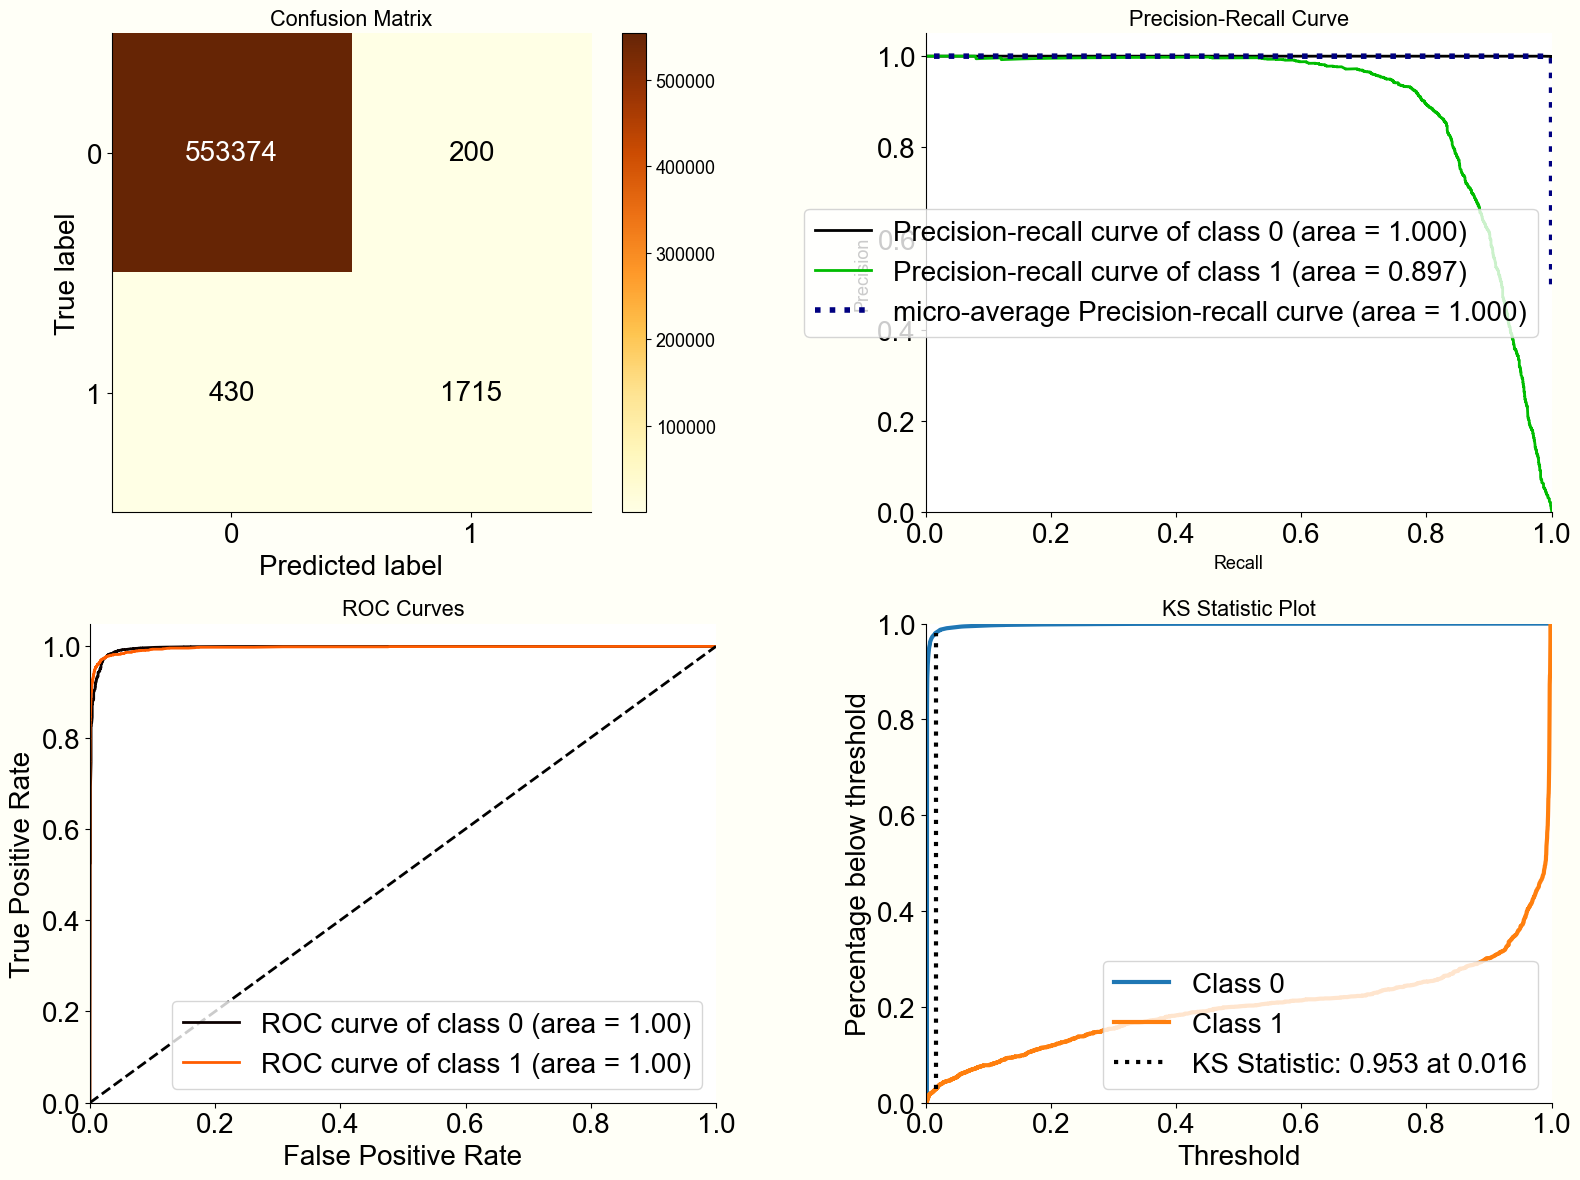

In [82]:
evaluation_plot(y_true=y_test, y_prob=y_prob)

## 7.2 XGboost No scale/No resampling

In [90]:
params_tuned =  {
                'eval_metric': 'auc',
                'reg_alpha': 0.000408919839116679,
                'reg_lambda': 0.00010735900318344515,
                'max_depth': 9,
                'n_estimators': 65,
                'learning_rate': 0.08444501230113413,
                }

In [151]:
xgb_tuned_def = xgb.XGBClassifier(**params_tuned, random_state=42)
pipe_xgb_def = Pipeline([('preprocessor', preprocessing), ('xgb_classifier', xgb_tuned_def)])

pipe_xgb_def.fit(X_train, y_train)

y_prob = pipe_xgb_def.predict_proba(X_test)
y_train_prob = pipe_xgb_def.predict_proba(X_train)

In [93]:
train_scores_def = classifier_metrics_tuned(clf_name='XGBoost (train) - no scale/no resampling', y_val=y_train, y_prob=y_train_prob)

train_scores_def

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (train) - no scale/no resampling,0.999024,0.909714,0.979708,0.849054,0.999031


In [94]:
test_scores_def = classifier_metrics_tuned(clf_name='XGBoost (test) - no scale/no resampling', y_val=y_test, y_prob=y_prob)

test_scores_def

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (test) - no scale/no resampling,0.998893,0.845903,0.91441,0.786946,0.996706


In [150]:
# saving the model with mlflow
#register_model(model=pipe_xgb_def, model_name='XGboost - no scale&no resampling', train_metrics=train_scores_def, test_metrics=test_scores_def,  params=params_tuned, metrics=scores, columns=cols, description='XGBoost noresample test performance.')

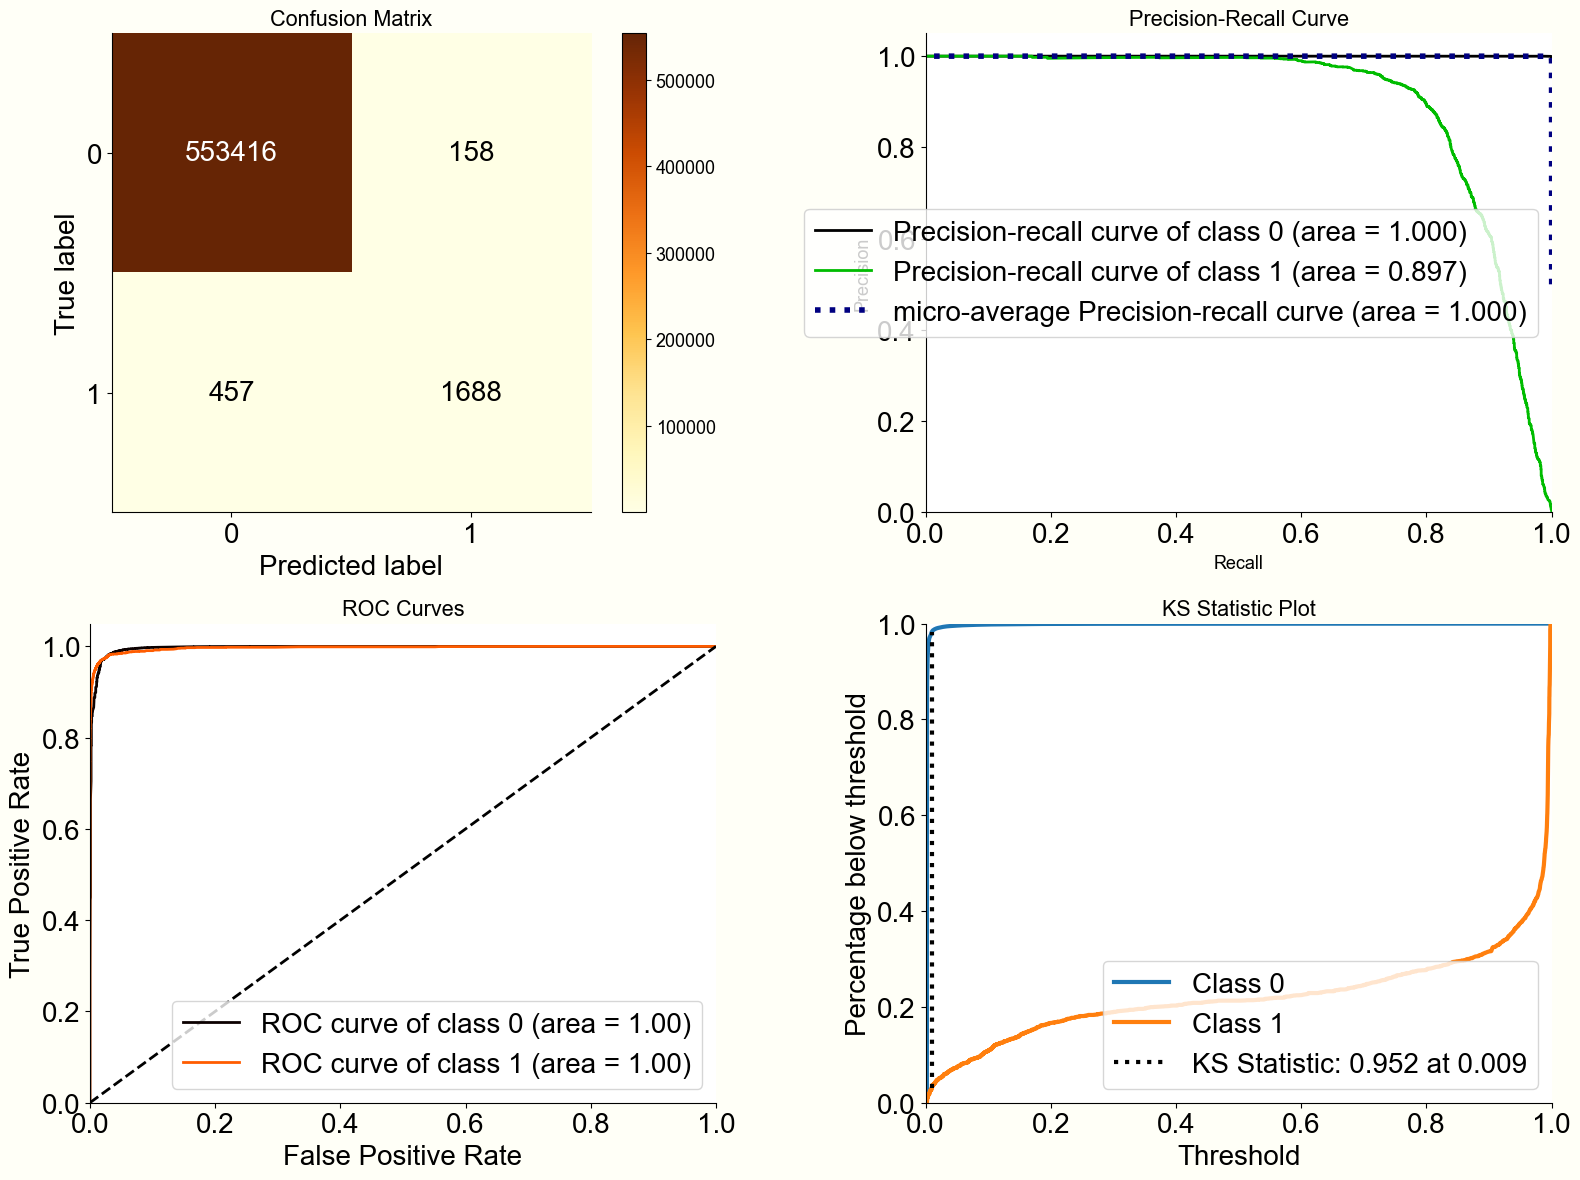

In [97]:
evaluation_plot(y_true=y_test, y_prob=y_prob)

In [98]:
#onehot_out = results.estimator[0][0][1].named_transformers_['onehot'].get_feature_names_out()
#cyclic_out = results.estimator[0][0][1].named_transformers_['cyclic'].get_feature_names_out()
#columns = np.concatenate([onehot_out, woe_cols, log_cols, robust_cols, pass_cols, cyclic_out])
#importances = results.estimator[0][1].feature_importances_

In [99]:
#plot_feature_importance(ordered_cols=columns, imp=importances)

# 8.0 SMOTE - Fine tuning.

In [ ]:
def objective(trial, x, y):

    # Defining parameters
    params = {
        'objective': 'binary:logistic',
        #'verbosity': 0,
        #'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['auc']),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 1e-1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda',  1e-4, 1e-1, log=True),
        #'max_leaves': trial.suggest_int('num_leaves', 8, 8188, step=20),
        'max_depth': trial.suggest_int('max_depth', 5, 12),
        'n_estimators': trial.suggest_int('n_estimators', 60, 260, step=5),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        #'subsample': trial.suggest_float('subsample', 0.2, 0.6, step=0.1),
    }

    xgb_mod_ov = xgb.XGBClassifier(**params, random_state=42)

    ovu_samp = imb.over_sampling.SMOTE(random_state=42, sampling_strategy=0.1)
    
    pipe_ovu = imb_pipe.Pipeline([('feat_eng', feat_eng), ('trans', transformer), ('sampler', ovu_samp), ('xgb', xgb_mod_ov)])


    scores = cross_val_score(pipe_ovu, x, y, cv=5, scoring='f1')

    score = scores.mean()

    return score

In [144]:
#sampler = TPESampler(seed=42)
#study = create_study(direction='maximize', sampler=sampler)
#logging.set_verbosity(logging.WARNING)
#study.optimize(lambda trial: objective(trial, X_train, y_train.values), n_trials=30)

In [39]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best Trial')
trial = study.best_trial
print(f'Value {trial.value}')
print('Param: ')
for key, value in trial.params.items():
    print(f'\'{key}\': {value},')

Number of finished trials: 30
Best Trial
Value 0.870718733074108
Param: 
'eval_metric': auc,
'reg_alpha': 0.006847920095574782,
'reg_lambda': 0.00026210878782654407,
'max_depth': 7,
'n_estimators': 135,
'learning_rate': 0.1422602954229404,


## 8.1 XGBoost + SMOTE with tuned params

In [103]:
#Best Trial
#Value 0.870718733074108
params_over =  {
                'eval_metric': 'auc',
                'reg_alpha': 0.006847920095574782,
                'reg_lambda': 0.00026210878782654407,
                'max_depth': 7,
                'n_estimators': 135,
                'learning_rate': 0.1422602954229404,
               }

In [105]:
xgb_smote_tuned = xgb.XGBClassifier(**params_over, random_state=42)
ovu_samp = imb.over_sampling.SMOTE(random_state=42, sampling_strategy=0.1)


pipe_smote_xgb = imb_pipe.Pipeline([('feat_eng', feat_eng), ('trans', transformer), ('sampler', ovu_samp), ('xgb_classifier', xgb_smote_tuned)])

pipe_smote_xgb.fit(X_train, y_train)

y_prob = pipe_smote_xgb.predict_proba(X_test)
y_train_prob = pipe_smote_xgb.predict_proba(X_train)

In [106]:
train_scores_smote = classifier_metrics_tuned(clf_name='XGBoost (train) + SMOTE', y_val=y_train, y_prob=y_train_prob)

train_scores_smote

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (train) + SMOTE,0.999041,0.913838,0.951673,0.878897,0.999459


In [107]:
test_scores_smote = classifier_metrics_tuned(clf_name='XGBoost (test) + SMOTE', y_val=y_test, y_prob=y_prob)

test_scores_smote

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (test) + SMOTE,0.998825,0.840693,0.881781,0.803263,0.997028


In [149]:
# saving the model with mlflow
#register_model(model=pipe_xgb, model_name='XGboost + SMOTE', train_metrics=train_scores_smote, test_metrics=test_scores_smote,  params=params_over, metrics=scores, columns=cols, description='XGBoost + SMOTE test performance.')

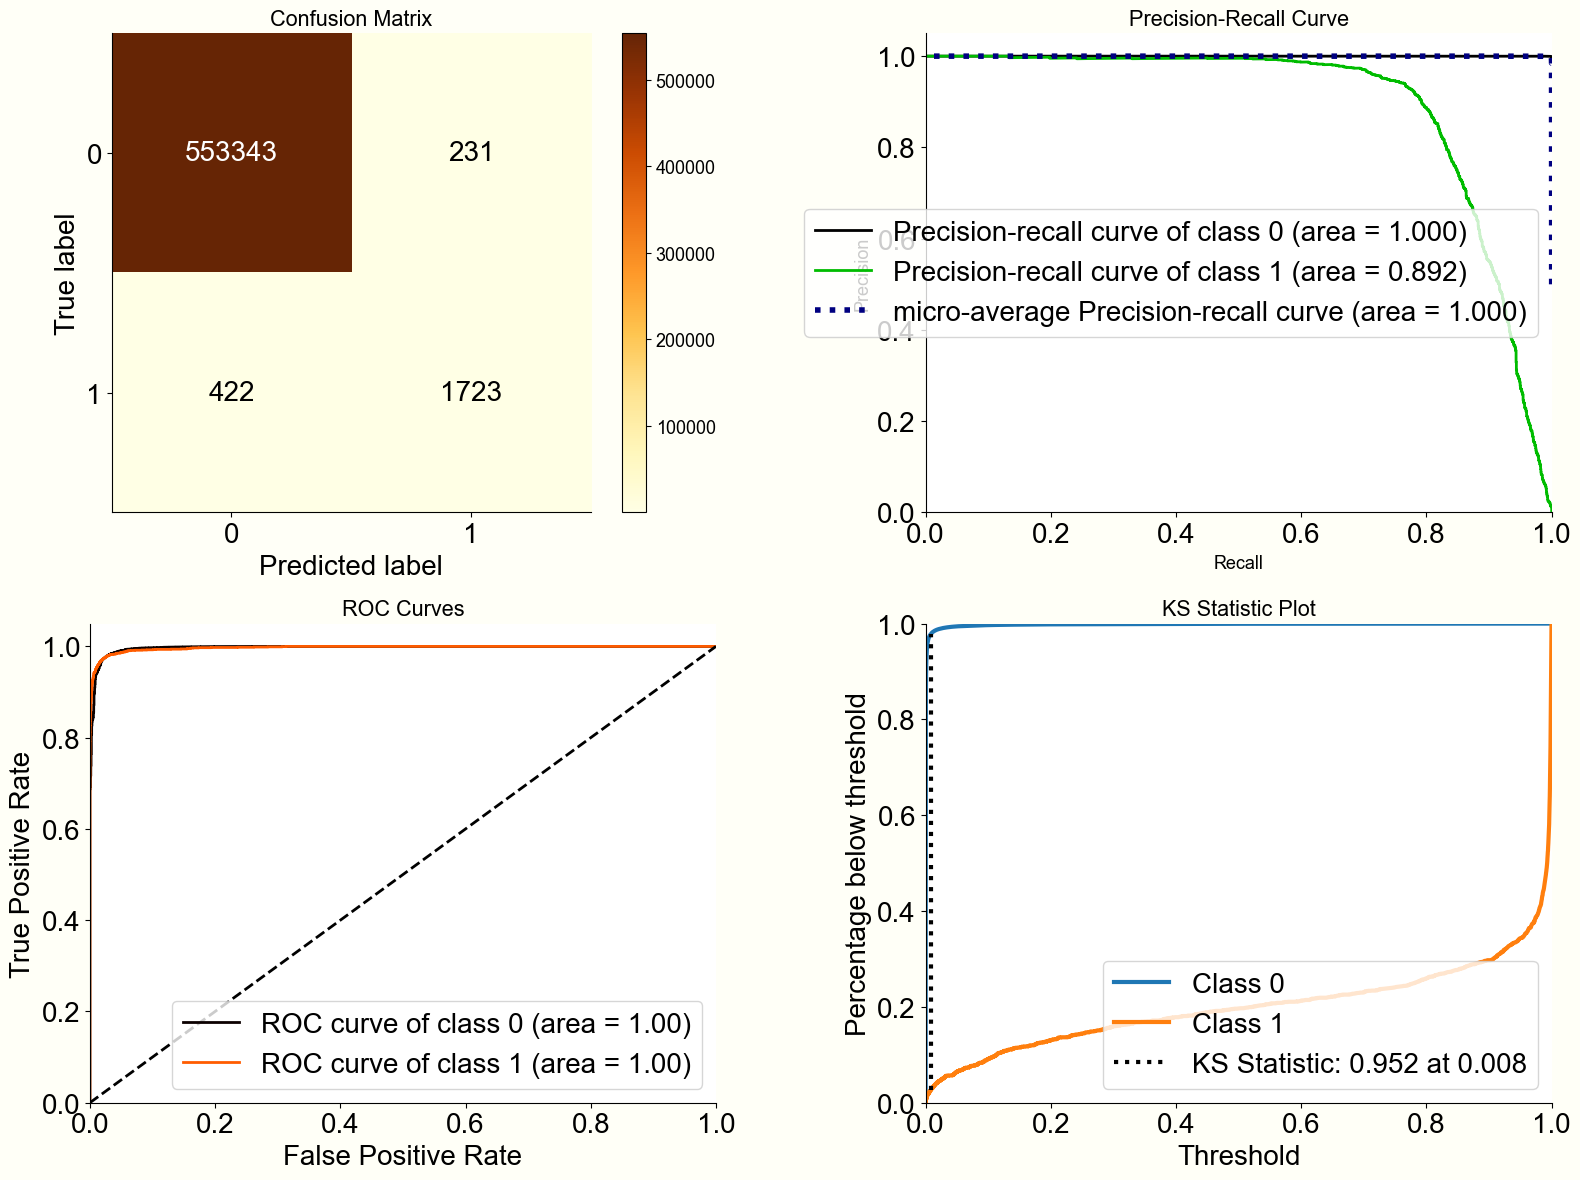

In [109]:
evaluation_plot(y_true=y_test, y_prob=y_prob)

## 8.2 XGBoost + SMOTE and Undersampling with tuned params

In [114]:
xgb_ovu_tuned = xgb.XGBClassifier(**params_over, random_state=42)
ov_samp = imb.over_sampling.SMOTE(random_state=42, sampling_strategy=0.1)
u_sampler = imb.under_sampling.RandomUnderSampler(sampling_strategy=0.6, random_state=42)

pipe_ovu_xgb = imb_pipe.Pipeline([('feat_eng', feat_eng), ('trans', transformer), ('sampler', ov_samp), ('under_samp', u_sampler), ('xgb_classifier', xgb_smote_tuned)])

pipe_ovu_xgb.fit(X_train, y_train)

y_prob = pipe_ovu_xgb.predict_proba(X_test)
y_train_prob = pipe_ovu_xgb.predict_proba(X_train)

In [115]:
train_scores_ovu = classifier_metrics_tuned(clf_name='XGBoost (train) + SMOTE + Random Undersampling', y_val=y_train, y_prob=y_train_prob)

train_scores_ovu

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (train) + SMOTE + Random Undersampling,0.997556,0.818197,0.718489,0.95004,0.999506


In [116]:
test_scores_ovu = classifier_metrics_tuned(clf_name='XGBoost (test) + SMOTE + Random Undersampling', y_val=y_test, y_prob=y_prob)

test_scores_ovu

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (test) + SMOTE + Random Undersampling,0.997213,0.71063,0.592893,0.886713,0.997475


In [148]:
# saving the model with mlflow
#register_model(model=pipe_xgb, model_name='XGboost + SMOTE + Random Undersampling', train_metrics=train_scores_smote, test_metrics=test_scores_smote,  params=params_over, metrics=scores, columns=cols, description='XGBoost + SMOTE + Random Undersampling test performance.')

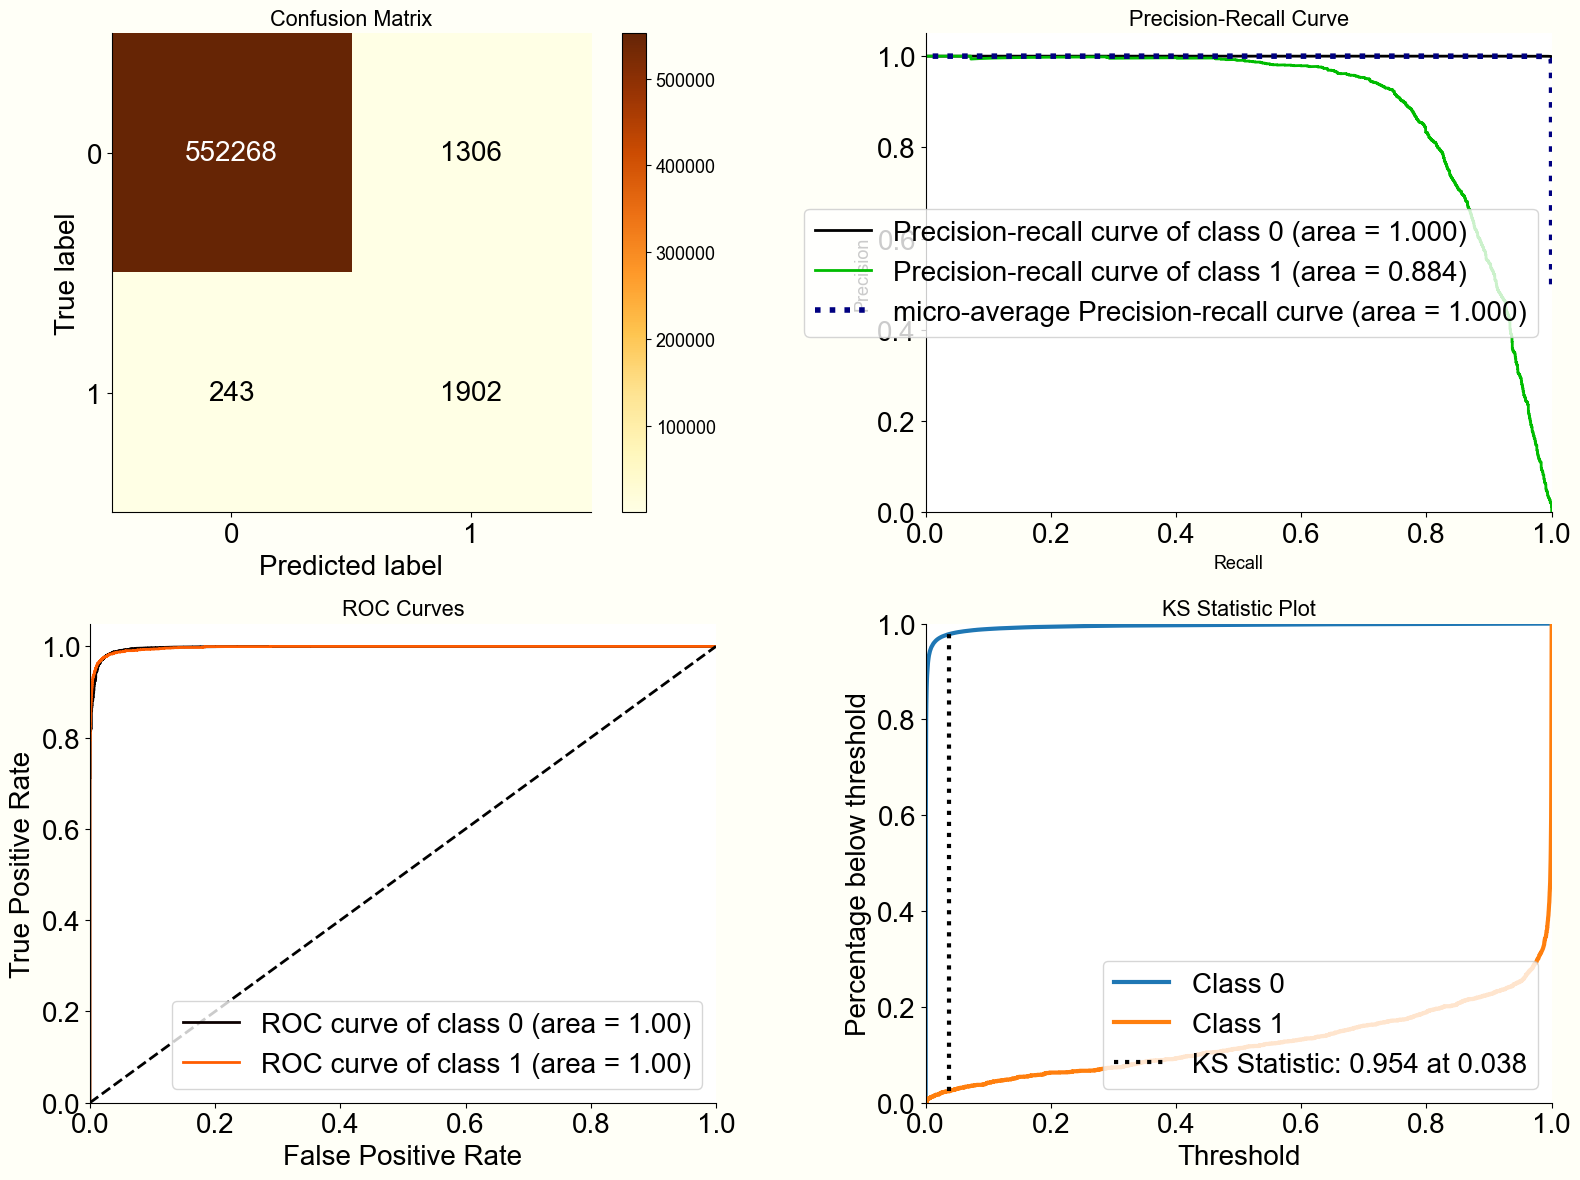

In [118]:
evaluation_plot(y_true=y_test, y_prob=y_prob)

## 8.3 Summary results of test performances

In [143]:
# summary
summary_test = pd.concat([test_scores_def, test_scores], axis=0) 
summary_test = pd.concat([summary_test, test_scores_smote], axis=0)
summary_test = pd.concat([summary_test, test_scores_ovu], axis=0)

summary_test.style.highlight_max(axis=0, color='darksalmon')

,accuracy,f1_score,precision,recall,roc_auc
XGBoost (test) - no scale/no resampling,0.998893,0.845903,0.914410,0.786946,0.996706
XGBoost (test) + scale_pos_weight,0.998866,0.844828,0.895561,0.799534,0.996825
XGBoost (test) + SMOTE,0.998825,0.840693,0.881781,0.803263,0.997028
XGBoost (test) + SMOTE + Random Undersampling,0.997213,0.710630,0.592893,0.886713,0.997475
